# US primary elections 2016

The idea of this notebook is to visualise the US primary election data and based on the insight use a model to predict the result of the election in future counties 

In [15]:
import numpy as np
import pandas as pd

In [16]:
demographicData = pd.read_csv("dataset\county_facts.csv")
resultData = pd.read_csv("dataset\primary_results.csv")

In [17]:
from bs4 import BeautifulSoup
import urllib

page = urllib.urlopen('http://2016.primary-caucus.org/?primary=state').read()
soup = BeautifulSoup(page, "lxml")

cells = [[] for i in range(57)]
j=-1
div = soup.find("div", {"id": "table610"})
table = div.find_all("table")[5]
for row in table.findAll("tr"):
    cell = row.findAll("td")[0].text.encode('ascii','ignore')
    if not '2016' in cell:
        if cell == '': 
            j+=1
            continue
        cell = cell.strip()
        cells[j].append(cell)
state_votingSystem = pd.DataFrame(cells, columns=['state','Republicans_system','Democrats_system'])
state_votingSystem['Democrats_system'][state_votingSystem['Democrats_system'].isnull()] = \
            state_votingSystem['Republicans_system'][state_votingSystem['Democrats_system'].isnull()]
state_votingSystem['Republicans_system'] = state_votingSystem['Republicans_system']\
            .replace({'Republican ':'','Democratic ':''}, regex=True)
state_votingSystem['Democrats_system'] = state_votingSystem['Democrats_system']\
            .replace({'Republican ':'','Democratic ':''}, regex=True)
state_votingSystem.to_csv('state_votingSystem.csv',sep=',')

In [18]:
resultData = resultData.merge(state_votingSystem, on='state', how='inner')
resultData.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,Republicans_system,Democrats_system
0,Iowa,IA,Adair,19001,Republican,Ted Cruz,104,0.256,caucuses,caucuses
1,Iowa,IA,Adair,19001,Republican,Donald Trump,104,0.256,caucuses,caucuses
2,Iowa,IA,Adair,19001,Republican,Marco Rubio,80,0.197,caucuses,caucuses
3,Iowa,IA,Adair,19001,Republican,Ben Carson,61,0.150,caucuses,caucuses
4,Iowa,IA,Adair,19001,Republican,Carly Fiorina,16,0.039,caucuses,caucuses


In [37]:
resultDataParty = resultData[resultData.party == "Republican"].reset_index()
resultDataGrouped = resultDataParty.groupby(["state_abbreviation", "county"])
winner = resultDataParty.loc[resultDataGrouped['fraction_votes'].transform('idxmax'),'candidate'].reset_index()
resultDataParty["winner"] = winner['candidate']
resultDataParty["totalVotes"] = resultDataParty["votes"]
votes = resultDataGrouped.agg({"votes": max, "fraction_votes": max, "winner": "first", "totalVotes": sum,\
                              "Republicans_system":"first", "Democrats_system":"first"})
votes.head()

votes        winner Republicans_system  \
state_abbreviation county                                              
IA                 Adair        104      Ted Cruz           caucuses   
                   Adams         81      Ted Cruz           caucuses   
                   Allamakee    193  Donald Trump           caucuses   
                   Appanoose    292  Donald Trump           caucuses   
                   Audubon      135      Ted Cruz           caucuses   

                             Democrats_system  totalVotes  fraction_votes  
state_abbreviation county                                                  
IA                 Adair             caucuses         405           0.256  
                   Adams             caucuses         272           0.297  
                   Allamakee         caucuses         686           0.281  
                   Appanoose         caucuses         839           0.348  
                   Audubon           caucuses         374           0.361

In [38]:
availableStates = resultData.state_abbreviation.unique()
#availableStates = ['IA', 'NV']
#availableStates = ['SC', 'NH']
availableStatesDemoData = demographicData[demographicData.state_abbreviation.isin(availableStates)]\
                                [['state_abbreviation', 'area_name', 'INC110213', 'RHI725214', 'RHI825214', 'EDU685213',\
                                  'SEX255214','SBO015207','PST045214','POP645213','POP815213']].reset_index()
availableStatesDemoData.rename(columns={'area_name':'county', 'INC110213':'income', 'RHI725214':'hispanic', 
                                'RHI825214':'white', 'EDU685213':'education', 'SEX255214':'females',\
                                'SBO015207':'femaleFirmOwner', 'PST045214':'population','POP815213':'nonEn_language',\
                                'POP645213':'notBornInUS'}, inplace=True)
availableStatesDemoData['county'] = availableStatesDemoData['county'].replace(' County', '',regex=True)
del availableStatesDemoData['index']
availableStatesDemoData["income"] = availableStatesDemoData["income"]/1000
availableStatesDemoData = availableStatesDemoData.set_index(["state_abbreviation", "county"])
availableStatesDemoData.head()

income  hispanic  white  education  females  \
state_abbreviation county                                                   
IA                 Adair      47.892       1.7   96.8       16.3     50.9   
                   Adams      45.871       1.1   96.9       13.7     49.9   
                   Allamakee  48.831       5.7   91.5       14.9     48.8   
                   Appanoose  39.208       1.5   96.2       18.3     50.6   
                   Audubon    48.313       1.1   97.3       16.6     51.6   

                              femaleFirmOwner  population  notBornInUS  \
state_abbreviation county                                                
IA                 Adair                  0.0        7454          1.1   
                   Adams                  0.0        3875          0.6   
                   Allamakee             22.8       14038          4.3   
                   Appanoose              0.0       12661          1.0   
                   Audubon                0.0        5794          0.6   

                              nonEn_language  
state_abbreviation county                     
IA                 Adair                 1.1  
                   Adams                 1.2  
                   Allamakee             8.0  
                   Appanoose             2.3  
                   Audubon               1.2

In [39]:
allData = pd.merge(votes, availableStatesDemoData, how="inner", left_index=True, right_index=True)
allData["turnout"] = allData.totalVotes/allData.population
allData.head()

votes        winner Republicans_system  \
state_abbreviation county                                              
IA                 Adair        104      Ted Cruz           caucuses   
                   Adams         81      Ted Cruz           caucuses   
                   Allamakee    193  Donald Trump           caucuses   
                   Appanoose    292  Donald Trump           caucuses   
                   Audubon      135      Ted Cruz           caucuses   

                             Democrats_system  totalVotes  fraction_votes  \
state_abbreviation county                                                   
IA                 Adair             caucuses         405           0.256   
                   Adams             caucuses         272           0.297   
                   Allamakee         caucuses         686           0.281   
                   Appanoose         caucuses         839           0.348   
                   Audubon           caucuses         374           0.361   

                              income  hispanic  white  education  females  \
state_abbreviation county                                                   
IA                 Adair      47.892       1.7   96.8       16.3     50.9   
                   Adams      45.871       1.1   96.9       13.7     49.9   
                   Allamakee  48.831       5.7   91.5       14.9     48.8   
                   Appanoose  39.208       1.5   96.2       18.3     50.6   
                   Audubon    48.313       1.1   97.3       16.6     51.6   

                              femaleFirmOwner  population  notBornInUS  \
state_abbreviation county                                                
IA                 Adair                  0.0        7454          1.1   
                   Adams                  0.0        3875          0.6   
                   Allamakee             22.8       14038          4.3   
                   Appanoose              0.0       12661          1.0   
                   Audubon                0.0        5794          0.6   

                              nonEn_language   turnout  
state_abbreviation county                               
IA                 Adair                 1.1  0.054333  
                   Adams                 1.2  0.070194  
                   Allamakee             8.0  0.048867  
                   Appanoose             2.3  0.066266  
                   Audubon               1.2  0.064550

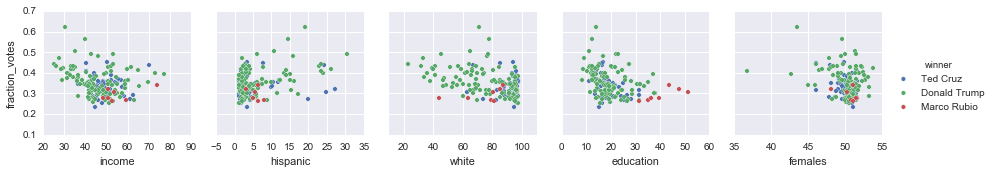

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

sns.pairplot(allData, hue="winner", 
             x_vars = ["income", "hispanic", "white", "education", 'females'], 
             y_vars = ["fraction_votes"])

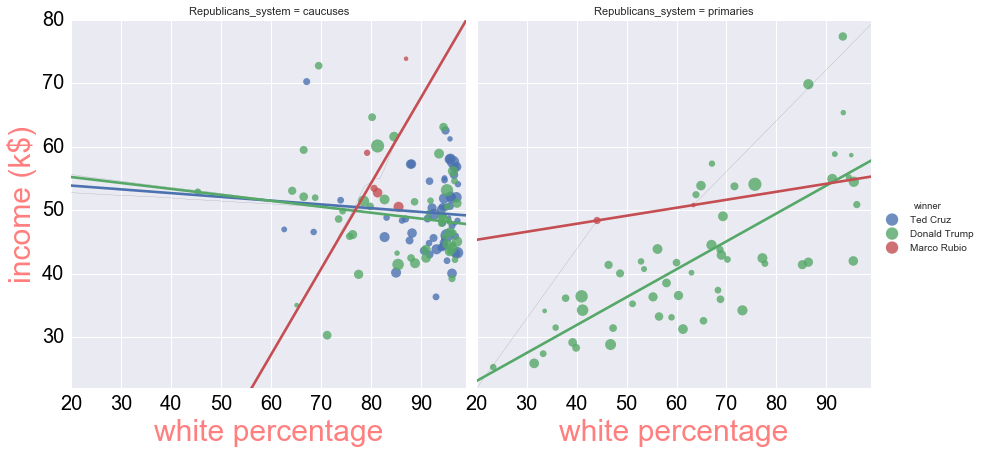

In [53]:
markerSize = (0.01+(allData.fraction_votes - allData.fraction_votes.min())/\
              (allData.fraction_votes.max() - allData.fraction_votes.min()))*300
g = sns.lmplot(x="white", y="income", data=allData, hue="winner", col='Republicans_system', ci=False, 
               scatter_kws={'s':markerSize}, size=6, legend_out=True, markers='o')
for ax in g.axes.flat:
    ax.tick_params(labelsize=20,labelcolor="black")
g.set_xlabels("white percentage", size = 30,color="r",alpha=0.5)
g.set_ylabels("income (k$)", size = 30,color="r",alpha=0.5)
g.set(xlim=(20, 99), ylim=(22, 80))

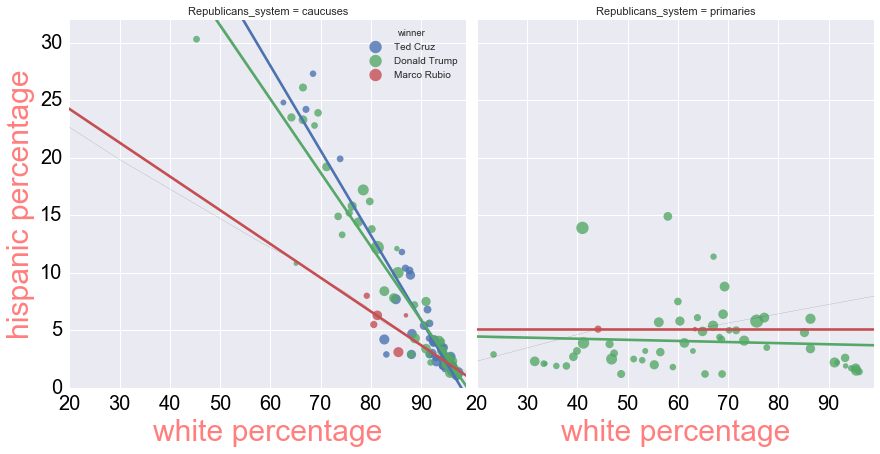

In [51]:
g = sns.lmplot(x="white", y="hispanic", data=allData, hue="winner", col='Republicans_system', ci=False, 
               scatter_kws={'s':markerSize}, size=6, legend_out=False)
for ax in g.axes.flat:
    ax.tick_params(labelsize=20,labelcolor="black")
g.set_xlabels("white percentage", size = 30,color="r",alpha=0.5)
g.set_ylabels("hispanic percentage", size = 30,color="r",alpha=0.5)
g.set(xlim=(20, 99), ylim=(0, 32))

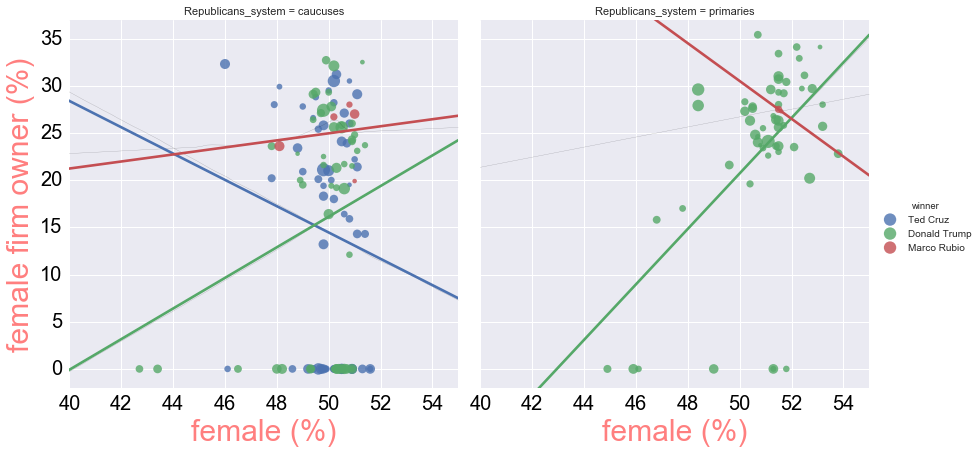

In [46]:
g = sns.lmplot(x="females", y="femaleFirmOwner", data=allData, hue="winner", col='Republicans_system', ci=False, 
               scatter_kws={'s':markerSize}, size=6, legend_out=True)
for ax in g.axes.flat:
    ax.tick_params(labelsize=20,labelcolor="black")
g.set_xlabels("female (%)", size = 30,color="r",alpha=0.5)
g.set_ylabels("female firm owner (%)", size = 30,color="r",alpha=0.5)
g.set(xlim=(40, 55), ylim=(-2, 37))

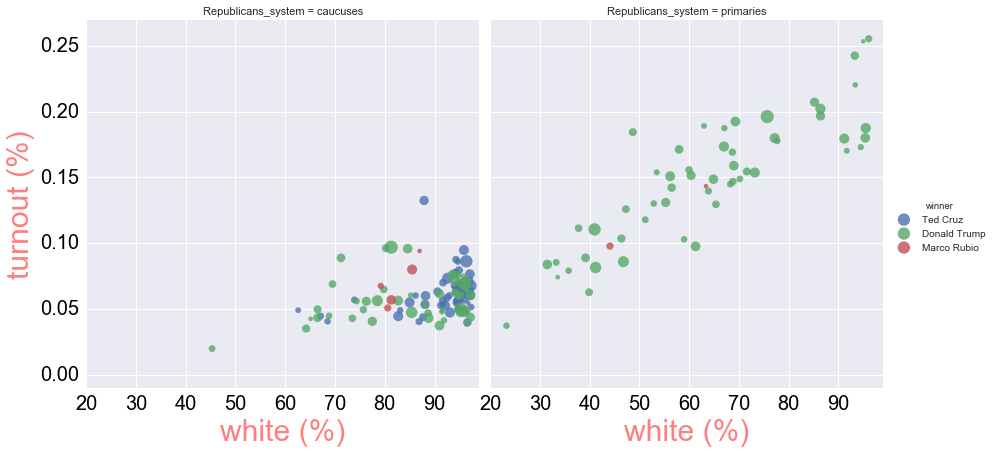

In [50]:
g = sns.lmplot(x="white", y="turnout", data=allData, hue="winner", col='Republicans_system', ci=False, 
               scatter_kws={'s':markerSize}, size=6, legend_out=True, fit_reg=False)
for ax in g.axes.flat:
    ax.tick_params(labelsize=20,labelcolor="black")
g.set_xlabels("white (%)", size = 30,color="r",alpha=0.5)
g.set_ylabels("turnout (%)", size = 30,color="r",alpha=0.5)
g.set(xlim=(20, 99), ylim=(-0.01, 0.27))

In [27]:
availableStates

array(['IA', 'NV', 'SC', 'NH'], dtype=object)

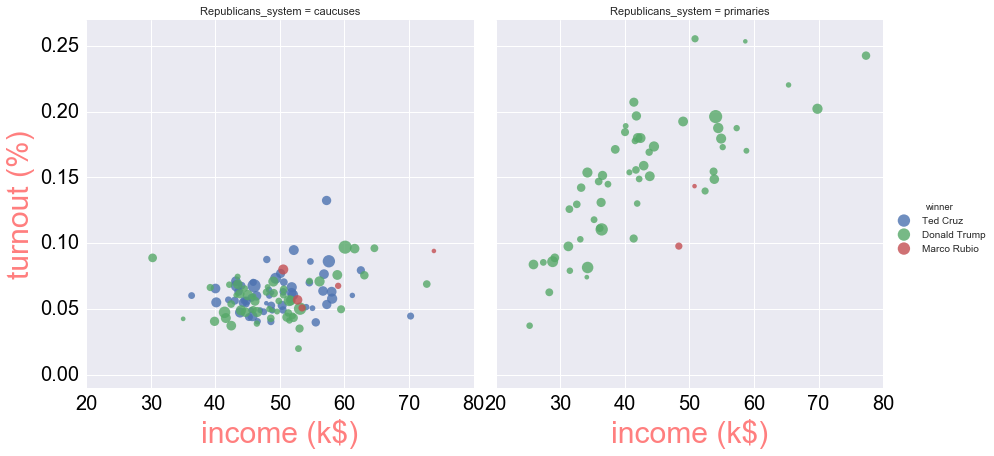

In [48]:
g = sns.lmplot(x="income", y="turnout", data=allData, hue="winner", col='Republicans_system', ci=False, 
               scatter_kws={'s':markerSize}, size=6, legend_out=True, fit_reg=False)
for ax in g.axes.flat:
    ax.tick_params(labelsize=20,labelcolor="black")
g.set_xlabels("income (k$)", size = 30,color="r",alpha=0.5)
g.set_ylabels("turnout (%)", size = 30,color="r",alpha=0.5)
g.set(xlim=(20, 80), ylim=(-0.01, 0.27))

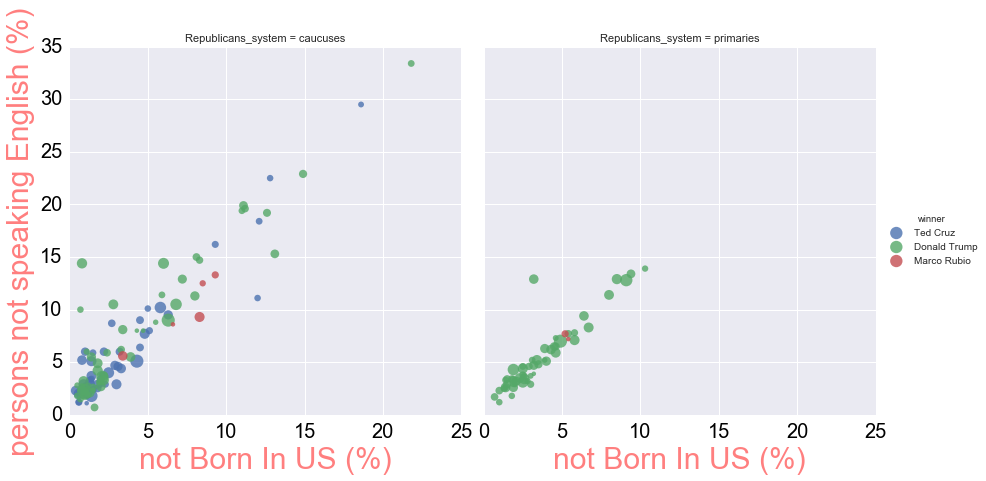

In [49]:
g = sns.lmplot(x="notBornInUS", y="nonEn_language", data=allData, hue="winner", col='Republicans_system', ci=False, 
               scatter_kws={'s':markerSize},size=6, legend_out=True, fit_reg=False)
for ax in g.axes.flat:
    ax.tick_params(labelsize=20,labelcolor="black")
g.set_xlabels("not Born In US (%)", size = 30,color="r",alpha=0.5)
g.set_ylabels("persons not speaking English (%)", size = 30,color="r",alpha=0.5)
g.set(xlim=(0, 25), ylim=(0, 35))